In [17]:
from common import *

if not os.path.exists(data_path):
    os.makedirs(data_path)

class Potential(Protocol):
    def value(self, r: Floating, theta: Floating) -> Floating:
        ...

@dataclass
class SimplePotential:
    d6: float
    r6: float

    factor_cos2: float
    factor_sin2: float

    shift_cos: float

    @staticmethod
    def default() -> "SimplePotential":
        return SimplePotential(500 * CM_INV, 10, 0, 0, 0)
    
    def value(self, r: Floating, theta:Floating) -> Floating:
        anisotropy = 1 + self.factor_cos2 * np.cos(theta) ** 2 + self.factor_sin2 * np.sin(theta) ** 2
        
        r6 = self.r6 * (1 + self.shift_cos * np.cos(theta))
        return self.d6 * (r6 / r) ** 6 * ((r6 / r) ** 6 - 2) * anisotropy

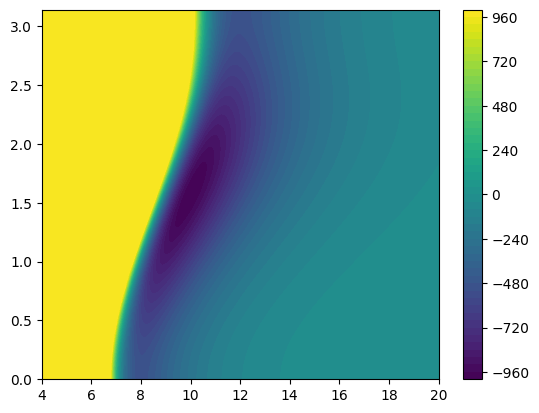

In [19]:
import matplotlib.pyplot as plt

r = np.linspace(4, 20, 300)
theta = np.linspace(0, np.pi, 100)

theta_mesh, r_mesh = np.meshgrid(theta, r, indexing="ij")
potential = SimplePotential.default()
potential.factor_sin2 = 1
potential.shift_cos = -0.2

potential_array = potential.value(r_mesh, theta_mesh) / CM_INV

potential_array = np.clip(potential_array, -10000, 1000)

fig, ax = plt.subplots()
CS = ax.contourf(r, theta, potential_array, levels=50)
fig.colorbar(CS)

pass

In [28]:
def prepare(j_init: int, 
    omega_init: int, 
    j_tot: int, 
    time_step: float = 100, 
    steps_no: float = 600, 
    r_start: float = 50 / 1024, 
    r_end: float = 50, 
    r_no: int = 1024, 
    polar_no: int = 160, 
    mass_u: float = 15.1052848671,
    energy_kelvin: float = 3700, 
    rot_const = 9.243165268327e-7,
    wave_r0: float = 30,
    wave_r_sigma: float = 0.6,
    animation: AnimationConfig = AnimationConfig.Polar,
    frames: int = 60,
    wave_prefix: str = "potentials",
    potential: Potential = SimplePotential.default(),
) -> split.Propagation:
    """
    Prepares the split operator propagation of the Ne OCS problem.

    :j_init: initial angular momentum of the OCS molecule
    :omega_init: initial body fixed projection of the OCS angular momentum equal to projection of the total angular momentum
    :j_tot: total angular momentum of the system
    :time_step: time step in the Hartree units of the propagation step
    :steps_no: number of steps in the propagation
    :r_start: starting value of the radial grid
    :r_end: ending value of the radial grid
    :r_no: number of points of the radial grid
    :polar_no: number of points of the angular grid
    :mass_u: reduced mass of the Ne OCS in u units
    :energy_kelvin: energy of the collision in Kelvin units
    :rot_const: rotational constant of the OCS molecule in Hartree units
    :wave_r0: initial radial position of the wave funciton
    :wave_r_sigma: initial radial width of the wave funciton
    :animation: animation configuration during the propagation
    :frames: number of frames of the animation
    :wave_prefix: prefix of the wave animation filename to be saved
    :potential: Potential to be used
    """

    assert j_tot >= omega_init
    assert j_init >= omega_init

    ############################ grids, wave function creation ################################
    
    time_grid = split.TimeGrid(time_step, steps_no)
    r_grid = split.Grid.linear_continuos("r", r_start, r_end, r_no, 0)
    
    polar_points, weights = roots_legendre(polar_no)
    polar_points = np.flip(np.arccos(polar_points))
    weights = np.flip(weights)
    
    polar_grid = split.Grid.custom("theta", polar_points, weights, 1)

    r_points = np.array(r_grid.points())
    momentum = np.sqrt(2 * mass_u * U * energy_kelvin * KELVIN)

    wave_r_init = np.array([split.gaussian_distribution(r_points[i], wave_r0, wave_r_sigma, momentum) for i in range(r_no)])
    wave_polar_init = lpmv(omega_init, j_init, np.cos(polar_points))

    wave_init = np.outer(wave_r_init, wave_polar_init)
    wave_function = split.WaveFunction(wave_init.flatten(), [r_grid, polar_grid])

    ############################ operation creation ################################

    r_mesh, polar_mesh = np.meshgrid(r_points, polar_points, indexing="ij")

    potential_array = potential.value(r_mesh, polar_mesh)

    centrifugal_potential = centrifugal(r_points, j_tot, omega_init, mass_u)
    centrifugal_potential = np.broadcast_to(np.expand_dims(centrifugal_potential, 1), (r_no, polar_no))

    potential_array = potential_array + centrifugal_potential
    potential_prop = split.n_dim_into_propagator(potential_array.shape, potential_array.flatten(), time_grid)

    leak_control = split.LeakControl(split.LossChecker("leak control"))
    dumping_border = split.BorderDumping(5., 1., r_grid)

    angular_transformation = split.associated_legendre_transformation(polar_grid, omega_init)

    shape, angular_kinetic_op = split.rotational_hamiltonian(r_grid, polar_grid, mass_u, rot_const)
    angular_prop = split.n_dim_into_propagator(shape, angular_kinetic_op, time_grid)

    fft_transformation = split.FFTTransformation(r_grid, "r momentum")

    kinetic_op = split.kinetic_hamiltonian(r_grid, mass_u, energy_kelvin)
    kinetic_prop = split.one_dim_into_propagator(kinetic_op, r_grid, time_grid, step = "full")

    ################################ populating operation stack ####################################

    operation_stack = split.OperationStack()
    potential_prop.add_operation(operation_stack)

    if AnimationConfig.Wave in animation:
        wave_saver = split.WaveFunctionSaver(data_path, f"{wave_prefix}_wave_animation", time_grid, r_grid, polar_grid, frames)
        wave_saver.add_operation(operation_stack)

    if AnimationConfig.Polar in animation:
        polar_saver = split.StateSaver(data_path, f"{wave_prefix}_polar_animation", time_grid, polar_grid, frames)
        polar_saver.add_operation(operation_stack)

    dumping_border.add_operation(operation_stack)
    leak_control.add_operation(operation_stack)

    angular_transformation.add_operation(operation_stack, True)

    if AnimationConfig.Angular in animation:
        angular_grid = angular_transformation.transformed_grid()
        wave_legendre_saver = split.StateSaver(data_path, f"{wave_prefix}_angular_animation", time_grid, angular_grid, frames)
        wave_legendre_saver.add_operation(operation_stack)

    angular_prop.add_operation(operation_stack)

    fft_transformation.add_operation(operation_stack, True)
    # todo!
    # if AnimationConfig.Momentum in animation: 
    #     wave_legendre_saver = split.StateSaver(data_path, f"{wave_prefix}_momentum_animation", time_grid, angular_grid, frames)
    #     wave_legendre_saver.add_operation(operation_stack)

    kinetic_prop.add_operation(operation_stack)

    ################################ propagation creation ####################################

    propagation = split.Propagation()
    propagation.set_wave_function(wave_function)
    propagation.set_time_grid(time_grid)
    propagation.set_operation_stack(operation_stack)

    return propagation

# Alignment calculation

In [29]:
from typing import Iterable

def get_alignments(potential: Potential, js: Iterable[int], prefix: str, j_tot = 150):
    for j in js:
        for omega in range(0, j+1):
            print(f"\r{prefix}\tj init: {j},\tomega init: {omega},\tj_tot: {j_tot}", end="")
            propagation = prepare(j, omega, j_tot, wave_prefix=f"{prefix}_{j}_{omega}")

            propagation.propagate()
            propagation.save_savers()

js = [0, 1, 5]

In [30]:
get_alignments(SimplePotential.default(), js, "factors_1_0")

factors_1_0	j init: 5,	omega init: 5,	j_tot: 150